# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-epsilon.new.72.fix.120.155.157.163.164.165'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
169609,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169610,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169611,2020-08-01,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169612,2020-08-02,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169613,2020-08-03,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
169609,2020-07-30,Colombia,Vichada,2,1,0,1
169610,2020-07-31,Colombia,Vichada,2,1,0,1
169611,2020-08-01,Colombia,Vichada,3,2,0,1
169612,2020-08-02,Colombia,Vichada,3,2,0,1
169613,2020-08-03,Colombia,Vichada,3,2,0,1


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
197,2020-07-30,12228,2789,330,9109
198,2020-07-31,12691,2921,332,9438
199,2020-08-01,13163,3216,332,9615
200,2020-08-02,13455,3508,332,9615
201,2020-08-03,13713,3589,333,9791


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-30,17334171,6551897,674512,10107762,0.019456,0.291556,0.062557
2020-07-31,17590630,6613440,680770,10296420,0.019350,0.292668,0.062017
2020-08-01,17871940,6694023,686269,10491648,0.019200,0.293523,0.061395
2020-08-02,18079942,6766159,689854,10623929,0.019078,0.293804,0.060975
2020-08-03,18138521,6778683,690721,10669117,0.019040,0.294101,0.060804


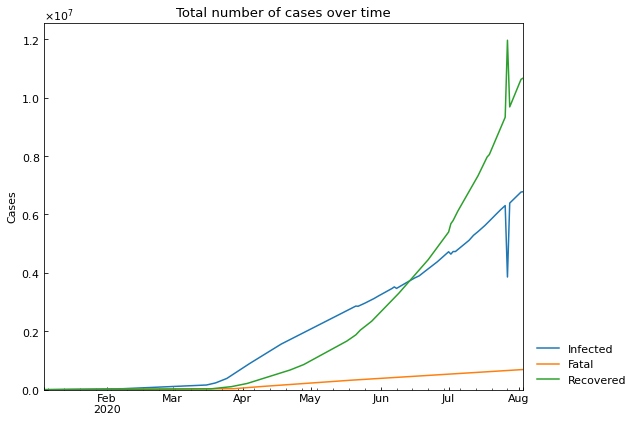

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
208,2020-07-30,34749,9569,1006,24174
209,2020-07-31,36330,10395,1012,24923
210,2020-08-01,37865,11356,1012,25497
211,2020-08-02,39195,12283,1012,25900
212,2020-08-03,40156,12657,1017,26482


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
169609,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169610,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169611,2020-08-01,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169612,2020-08-02,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169613,2020-08-03,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
166377,COL,Colombia,Vichada,2020-07-30,107808
166378,COL,Colombia,Vichada,2020-07-31,107808
166379,COL,Colombia,Vichada,2020-08-01,107808
166380,COL,Colombia,Vichada,2020-08-02,107808
166381,COL,Colombia,Vichada,2020-08-03,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
169609,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169610,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169611,2020-08-01,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169612,2020-08-02,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
169613,2020-08-03,3,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
169609,2020-07-30,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
169610,2020-07-31,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
169611,2020-08-01,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
169612,2020-08-02,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
169613,2020-08-03,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
208,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
209,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
210,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41
211,2020-08-02,1,1,1,0,0,1,1,3,2,2,1,32.41
212,2020-08-03,1,1,1,0,0,1,1,3,2,2,1,32.41


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
208,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
209,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
210,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41
211,2020-08-02,1,1,1,0,0,1,1,3,2,2,1,32.41
212,2020-08-03,1,1,1,0,0,1,1,3,2,2,1,32.41


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

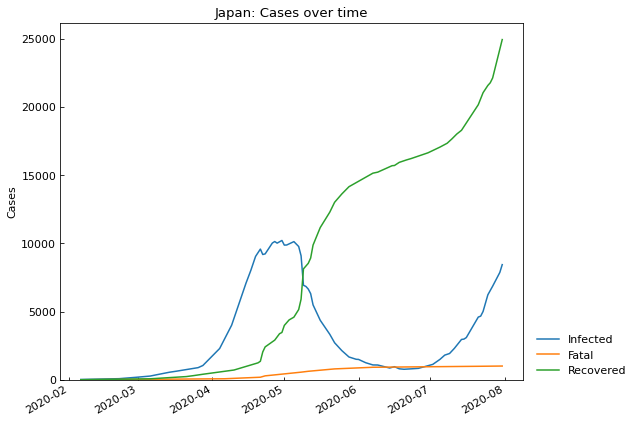

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

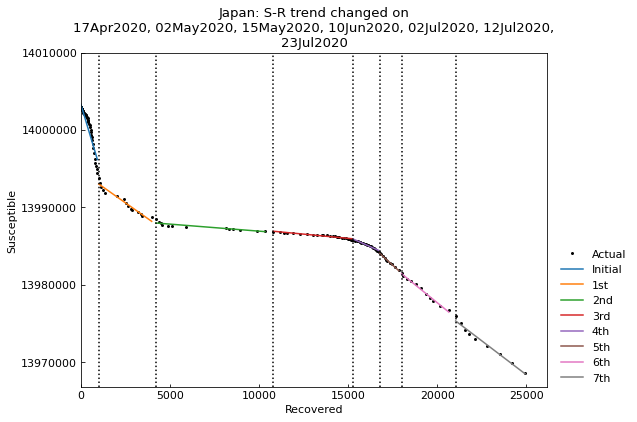

,Type,Start,End,Population
1st,Past,17Apr2020,01May2020,14002973
2nd,Past,02May2020,14May2020,14002973
3rd,Past,15May2020,09Jun2020,14002973
4th,Past,10Jun2020,01Jul2020,14002973
5th,Past,02Jul2020,11Jul2020,14002973
6th,Past,12Jul2020,22Jul2020,14002973
7th,Past,23Jul2020,31Jul2020,14002973


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<Main scenario: parameter estimation>

Running optimization with 4 CPUs...

	7th phase with SIR-F model: finished 644 trials in 0 min 20 sec

	3rd phase with SIR-F model: finished 486 trials in 0 min 20 sec

	5th phase with SIR-F model: finished 375 trials in 0 min 15 sec

	6th phase with SIR-F model: finished 302 trials in 0 min 10 sec

	1st phase with SIR-F model: finished 1414 trials in 1 min 0 sec

	2nd phase with SIR-F model: finished 1420 trials in 1 min 0 sec

	4th phase with SIR-F model: finished 1447 trials in 1 min 0 sec

Completed optimization. Total: 1 min 21 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,17Apr2020,01May2020,14002973,SIR-F,0.021313,0.011157,0.021487,0.000696,720,1.76,0.021,717,23,44,0.134299,1414,1 min 0 sec
2nd,Past,02May2020,14May2020,14002973,SIR-F,0.006628,0.031992,0.132876,0.000350,720,0.18,0.133,1429,75,15,0.167361,1420,1 min 0 sec
3rd,Past,15May2020,09Jun2020,14002973,SIR-F,0.008983,0.039896,0.137876,0.000618,720,0.19,0.138,809,55,12,0.118772,486,0 min 20 sec
4th,Past,10Jun2020,01Jul2020,14002973,SIR-F,0.032189,0.035970,0.020570,0.000581,720,0.86,0.021,860,15,13,0.141996,1447,1 min 0 sec
5th,Past,02Jul2020,11Jul2020,14002973,SIR-F,0.073661,0.033451,0.000066,0.000153,720,2.19,0.000,3258,6,14,0.026701,375,0 min 15 sec
6th,Past,12Jul2020,22Jul2020,14002973,SIR-F,0.066475,0.034147,0.001257,0.000002,720,1.94,0.001,265668,7,14,0.022663,302,0 min 10 sec
7th,Past,23Jul2020,31Jul2020,14002973,SIR-F,0.069036,0.035356,0.000666,0.000073,720,1.95,0.001,6876,7,14,0.031473,644,0 min 20 sec


### Accuracy of estimation

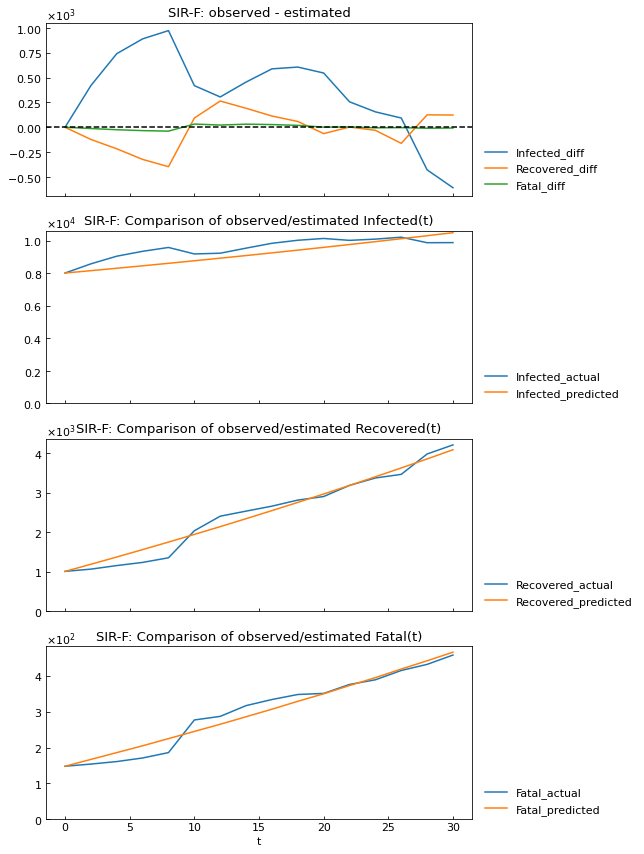

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

0.86

### Show parameter history

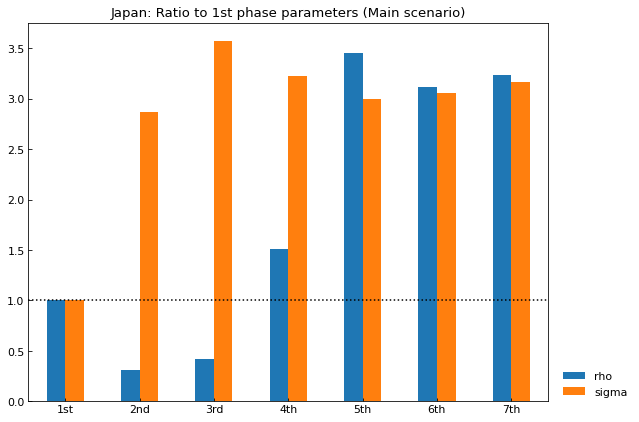

,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.310991,0.421476,1.510331,3.456224,3.119042,3.239219
sigma,1.0,2.867442,3.575825,3.223942,2.998197,3.060536,3.168891


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

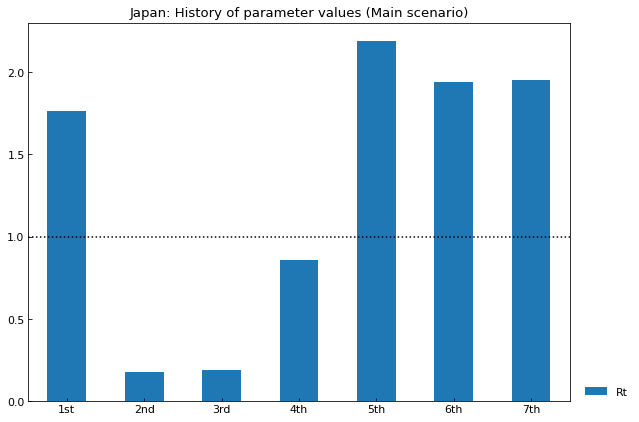

,1st,2nd,3rd,4th,5th,6th,7th
Rt,1.76,0.18,0.19,0.86,2.19,1.94,1.95


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

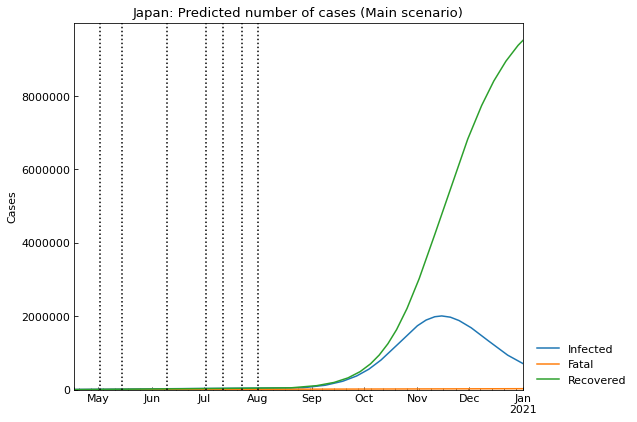

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,26863,801149,9321890,3853069
256,29Dec2020,26998,775114,9377617,3823244
257,30Dec2020,27128,749708,9431524,3794612
258,31Dec2020,27253,724936,9483657,3767126
259,01Jan2021,27345,706752,9521673,3747203


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.03535566756310582

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.07071133512621164

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     0th      Past  17Apr2020  01May2020    14002973  SIR-F  0.021313   
         1st      Past  02May2020  14May2020    14002973  SIR-F  0.006628   
         2nd      Past  15May2020  09Jun2020    14002973  SIR-F  0.008983   
         3rd      Past  10Jun2020  01Jul2020    14002973  SIR-F  0.032189   
         4th      Past  02Jul2020  11Jul2020    14002973  SIR-F  0.073661   
         5th      Past  12Jul2020  22Jul2020    14002973  SIR-F  0.066475   
         6th      Past  23Jul2020  31Jul2020    14002973  SIR-F  0.069036   
         7th    Future  01Aug2020  01Jan2021    14002973  SIR-F  0.069036   
Medicine 0th      Past  17Apr2020  01May2020    14002973  SIR-F  0.021313   
         1st      Past  02May2020  14May2020    14002973  SIR-F  0.006628   
         2nd      Past  15May2020  09Jun2020    14002973  SIR-F  0.008983   
         3rd      Past  10Jun2020  01Jul2020    14002973  SIR-F  0.032189   
         4th      Past  02Jul2020  11Jul2020    14002973  SIR-F  0.073661   
         5th      Past  12Jul2020  22Jul2020    14002973  SIR-F  0.066475   
         6th      Past  23Jul2020  31Jul2020    14002973  SIR-F  0.069036   
         7th    Future  01Aug2020  31Aug2020    14002973  SIR-F  0.069036   
         8th    Future  01Sep2020  01Jan2021    14002973  SIR-F  0.069036   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     0th    0.011157  0.021487  0.000696  720  1.76       0.021   
         1st    0.031992  0.132876  0.000350  720  0.18       0.133   
         2nd    0.039896  0.137876  0.000618  720  0.19       0.138   
         3rd    0.035970  0.020570  0.000581  720  0.86       0.021   
         4th    0.033451  0.000066  0.000153  720  2.19       0.000   
         5th    0.034147  0.001257  0.000002  720  1.94       0.001   
         6th    0.035356  0.000666  0.000073  720  1.95       0.001   
         7th    0.035356  0.000666  0.000073  720  1.95       0.001   
Medicine 0th    0.011157  0.021487  0.000696  720  1.76       0.021   
         1st    0.031992  0.132876  0.000350  720  0.18       0.133   
         2nd    0.039896  0.137876  0.000618  720  0.19       0.138   
         3rd    0.035970  0.020570  0.000581  720  0.86       0.021   
         4th    0.033451  0.000066  0.000153  720  2.19       0.000   
         5th    0.034147  0.001257  0.000002  720  1.94       0.001   
         6th    0.035356  0.000666  0.000073  720  1.95       0.001   
         7th    0.035356  0.000666  0.000073  720  1.95       0.001   
         8th    0.070711  0.000666  0.000073  720  0.97       0.001   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     0th               717            23             44   0.134299   1414   
         1st              1429            75             15   0.167361   1420   
         2nd               809            55             12   0.118772    486   
         3rd               860            15             13   0.141996   1447   
         4th              3258             6             14  0.0267009    375   
         5th            265668             7             14  0.0226629    302   
         6th              6876             7             14  0.0314728    644   
         7th              6876             7             14          -      -   
Medicine 0th               717            23             44   0.134299   1414   
         1st              1429            75             15   0.167361   1420   
         2nd               809            55             12   0.118772    486   
         3rd               860            15             13   0.141996   1447   
         4th              3258             6             14  0.0267009

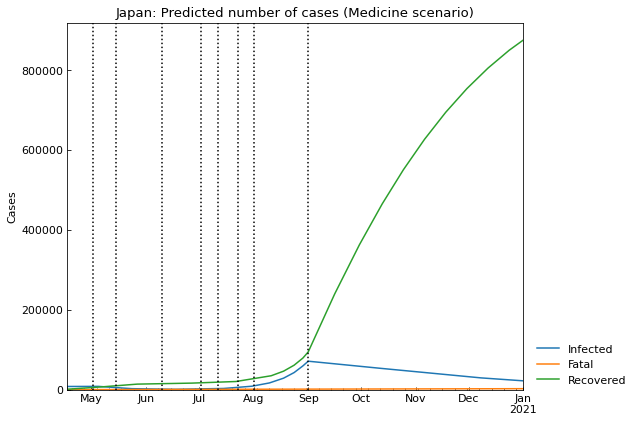

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,2502,23243,862656,13114571
256,29Dec2020,2508,22958,865923,13111584
257,30Dec2020,2513,22675,869149,13108634
258,31Dec2020,2518,22395,872336,13105722
259,01Jan2021,2523,22187,874702,13103561


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,2008839,15Nov2020,706752,27345
Medicine,71296,01Sep2020,22187,2523
